# Earth Temperature Spiraling towards +2°C
On 9 May 2016 [Ed Hawkins](http://www.climate-lab-book.ac.uk/author/ed/), a climate scientist at the University of Reading in the United Kingdom [published](http://www.climatecentral.org/news/see-earths-temperature-spiral-toward-2c-20332) this striking animated graph featuring a rainbow-colored record of global temperatures spinning outward from the late 19th century to the present as the Earth heats up.  

Some periods stand out:
+ 1877-78: strong El Nino event warms global temperatures
+ 1880s-1910: small cooling, partially due to volcanic eruptions
+ 1910-1940s: warming, partially due to recovery from volcanic eruptions, small increase in solar output and natural variability
+ 1950s-1970s: fairly flat temperatures as cooling sulphate aerosols mask the greenhouse gas warming
+ 1980-now: strong warming, with temperatures pushed higher in 1998 and 2016 due to strong El Nino events

The purpose of this notebook is to enable you to 
+ update the data each time you run it
+ allow better navigation across time


<img src="http://assets.climatecentral.org/images/uploads/news/5_9_16_Andrea_TempSpiralEdHawkins.gif" width="500px">


In [1]:
%matplotlib inline

import os
import shutil
import datetime as dt
import requests as rq
import numpy as np
import pandas as pd
import jinja2 as jj
import matplotlib.pyplot as pl

from IPython.display import IFrame

print(dt.datetime.today())

2018-11-12 22:15:08.704831


## Data Source

In [2]:
url = 'https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt'
print('Data source: {}'.format(url.split('/data')[0]))
print('Raw data: {}'.format(url))

filename = url[url.rfind("/")+1:]
folder = 'data'
path = os.path.join(folder, filename)

Data source: https://www.metoffice.gov.uk/hadobs/hadcrut4
Raw data: https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt


## Download raw data

In [3]:
r = rq.get(url)
data = r.content.decode('utf-8')

if not os.path.exists(folder):
    os.makedirs(folder)

with open(path, 'w') as f:
    f.write(data)
    print('file {} saved on disk'.format(path))

file data/HadCRUT.4.6.0.0.monthly_ns_avg.txt saved on disk


## Shape data
+ Reference average world temperature set to <span style="color:orange">**1850-1900 mean**</span>

In [4]:
df = pd.read_csv(path, delim_whitespace=True, header=None, usecols=[0, 1])
df.columns = ['year/month', 'value']

print('raw data')
df.info()

df['date'] = pd.to_datetime(df['year/month'].map(lambda x: dt.datetime.strptime('15/'+x, '%d/%Y/%m')))
df = df.set_index('date')
df['year'] = df.index.year
df['month'] = df.index.month
df = df.drop('year/month', axis=1)

# set average to mean 1850-1900 temperature
df['value'] -= df.loc['1850':'1900', 'value'].mean()

path2 = os.path.join(folder, 'df_data.csv')
df.to_csv(path2)

print('\ndf_data')
df.info()

raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025 entries, 0 to 2024
Data columns (total 2 columns):
year/month    2025 non-null object
value         2025 non-null float64
dtypes: float64(1), object(1)
memory usage: 31.7+ KB

df_data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2025 entries, 1850-01-15 to 2018-09-15
Data columns (total 3 columns):
value    2025 non-null float64
year     2025 non-null int64
month    2025 non-null int64
dtypes: float64(1), int64(2)
memory usage: 143.3 KB


## Simple plot

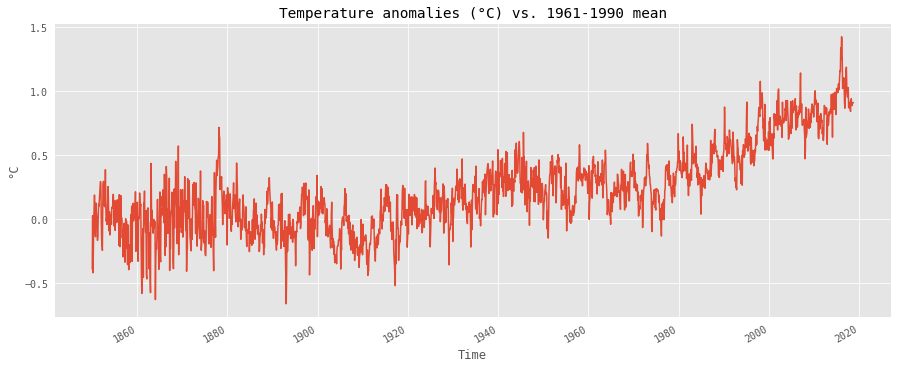

In [5]:
pl.style.available
pl.style.use('ggplot')

s = df['value']
ax = s.plot(figsize=(15 ,6))
ax.set_xlabel('Time')
ax.set_title('Temperature anomalies (°C) vs. 1961-1990 mean')
ax.set_ylabel('°C');


## Extreme temperature deviations

In [6]:
N = 10
smin = s.sort_values()[:N]
smin.name = '{} Lower deviations'.format(N)
df_min = pd.DataFrame(smin)
smax = s.sort_values(ascending=False)[:N]
smax.name = '{} Higher deviations'.format(N)
df_max = pd.DataFrame(smax)

pd.concat([df_min.reset_index(), df_max.reset_index()], axis=1)


date  10 Lower deviations       date  10 Higher deviations
0 1893-01-15            -0.660559 2016-02-15              1.424441
1 1864-01-15            -0.627559 2016-03-15              1.419441
2 1861-01-15            -0.579559 2015-12-15              1.337441
3 1862-12-15            -0.573559 2016-04-15              1.250441
4 1917-03-15            -0.518559 2016-01-15              1.247441
5 1892-12-15            -0.479559 2017-03-15              1.186441
6 1862-02-15            -0.466559 2017-02-15              1.158441
7 1861-05-15            -0.454559 2015-10-15              1.158441
8 1862-11-15            -0.452559 2015-11-15              1.153441
9 1917-02-15            -0.451559 2007-01-15              1.141441

## Build visualisation
+ Based on [d3.js](https://d3js.org/)
+ to run outside the notebook `bash serve.sh` in relevant folder (**.data/** for `prod` mode and **.data/dev/** for `dev` mode)
    + After `npm install live-server`

In [7]:
with open(path2, 'r') as f:
    df_data_csv = f.read()

loader = jj.FileSystemLoader('templates')
env = jj.Environment(loader=loader,
                     variable_start_string='__$',
                     variable_end_string='$__',
                     block_start_string='{-%',
                     block_end_string='%-}'
                     )

folder_dev = os.path.join(folder, 'dev')
if not os.path.exists(folder_dev):
    os.makedirs(folder_dev)

def save(content, name, mode='dev'):
    if mode == 'dev':
        path = os.path.join(folder, 'dev', name)
    else:
        path = os.path.join(folder, name)
    with open(path, 'w') as f:
        f.write(content)
    print('\tfile {} saved to disk'.format(path))


###### dev mode
print('dev mode')
data = {'df_data_csv': df_data_csv, 'dev': True, 'uuid': '0', 'test': 22}

for e in['index.html', 'index_dev.js', 'style.css', 'manipulate.js', 'manipulate.css']:
    name, ext = e.split('.')
    template = env.get_template('{}.tpl.{}'.format(name, ext))    
    content = template.render(data=data)
    name = name.split('_dev')[0]
    save(content, '{}.{}'.format(name, ext), mode='dev')
shutil.copy(os.path.join(folder, 'df_data.csv'), 
            os.path.join(folder, 'dev', 'df_data.csv'))

save('live-server --port=4000', 'serve.sh', mode='dev')

###### prod mode
print('prod mode')
uuid = np.random.randint(1e6)
data = {'df_data_csv': df_data_csv, 'dev': False, 'uuid': uuid}

template = env.get_template('index.tpl.html')
content = template.render(data=data)
save(content, 'index.html', mode='prod')

save('live-server --port=4001', 'serve.sh', mode='prod')


dev mode
	file data/dev/index.html saved to disk
	file data/dev/index.js saved to disk
	file data/dev/style.css saved to disk
	file data/dev/manipulate.js saved to disk
	file data/dev/manipulate.css saved to disk
	file data/dev/serve.sh saved to disk
prod mode
	file data/index.html saved to disk
	file data/serve.sh saved to disk


## Render visualisation

In [8]:
path4 = os.path.join(folder, 'index.html')
# IFrame(path4, width=950, height=800)

## NbViewer

In [9]:
url = 'https://gitlab.com/oscar6echo/earth-temperature-spiral/raw/master/data/index.html'
# https://raw.githack.com/
url = 'https://glcdn.githack.com/oscar6echo/earth-temperature-spiral/raw/master/data/index.html'
# url with commit to avoid long cache
url = 'https://glcdn.githack.com/oscar6echo/earth-temperature-spiral/raw/a0a44e69b55037fdb5a50bcc6de63fe65a62c604/data/index.html'
IFrame(url, width=950, height=800)